# Deep learning for natural language processing

In previous practical works, you have learned the basics of Python programming, how to process a textual dataset, how to extract features such as TF-IDF, and how to train different machine learning models, including SVMs and MLPs (feed-forward neural networks), using the sklearn package. However, the sklearn package does not allow you to design and train custom neural networks in more detail. Therefore, here you will learn how to use pytorch to define, train and evaluate your own neural network model for different tasks. You will also learn the basics of deep learning and how to use pre-trained deep representations of data, such as BERT models, instead of traditional TF-IDF functions. Below is a list of things you will learn in this practical work.

- Training TF-IDFs using SVMs (from previous practical work)
- Designing a neural network model with Pytorch
- Training a Pytorch model
- Plotting and analysing training vs development loss
- Evaluation of a trained pytorch model
- Using huggingface to load BERT models
- Using BERT representations for training machine learning models


## Setting up the environment

Before we start with the practical work, we need to install and import the packages we will be using. To do so, run the scripts below:

In [ ]:
%pip install numpy==1.24.1
%pip install pandas==1.5.3
%pip install -U scikit-learn==1.2.1
%pip install scipy==1.10.0
%pip install matplotlib==3.6.3
%pip install torch==1.13.1
%pip install transformers==4.26.1
%pip install sacremoses # only for flaubert

In [19]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from transformers import DistilBertTokenizer DistilBertModel
from transformers import FlaubertTokenizer, FlaubertModel

In [ ]:
# Just a useful function to see the progress when running a loop
def printProgressBar (iteration: int, total: int, prefix = '', suffix = '', decimals = 1, length = "fit", fill = '█') -> None:
    """Prints a progress bar on the terminal
    """
    if length=="fit":
        rows, columns = os.popen('stty size', 'r').read().split() # checks how wide the terminal width is
        length = int(columns) // 2
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    if iteration == total: # go to new line when the progress bar is finished
        print()

## Defining metrics (from previous work)

Here, as the task is classification, we will work with `accuracy` and `Unweighted Average Recall (UAR)`. For more infromation please check the previous practical work.

In [20]:
def accuracy(outs:list, tars:list) -> float:
    """
    Calculating and returning the accuracy between outputs (`outs`) and targets (`tars`),
    where each one is a list of integers like [1,0,1,2,2,1,0,3], with each integer indicating the target label
    """
    accuracy = np.mean([out==tar for out, tar in zip(outs, tars)])
    return accuracy

def UAR(outs:list, tars:list) -> float:
    """
    Calculating and returning the unweighted average recall between outputs (`outs`) and targets (`tars`),
    where each one is a list of integers like [1,0,1,2,2,1,0,3], with each integer indicating the target label
    """
    tarsSet = list(set(tars))
    corrects = {}
    totals = {}
    for i in tarsSet:
        corrects[i] = 0
        totals[i] = 0
    for i, out in enumerate(outs):
        tar = tars[i]
        totals[tar] += 1
        if out == tar: corrects[tar] += 1 # Counting when target and output match per each class 
    uar = 0
    for i in tarsSet:
        uar += corrects[i] / totals[i] # Calculating the accuracy per each class 
    uar = uar / len(tarsSet) # Calculating the average of accuracies per each class 
    return uar

outputs = [1,1,1,1,0,1,1,1]
targets = [0,0,1,1,1,1,1,1]
print("Accuracy example:", accuracy(outputs, targets))
print("UAR example:", UAR(outputs, targets))

Accuracy example: 0.625
UAR example: 0.4166666666666667


## Processing a textual dataset (from previous work)

Here, we will learn how to load a textual dataset, and extract `tf-idf` features for machine learning (`tf-idf` was the subject of the previous practical work). Here, we will focus on a sentiment analysis dataset, called `Allociné`, which consists of reviews of French television series. These reviews can be positive (labelled `1`) or negative (labelled `0`). In this section, we do the following:

- Download the `Allociné` corpus
- Load the three partitions of `train`, `dev`, and `test` into memory
- Extract `tf-idf` features for each partition
- Read sentiment targets as numerical values, ready for machine learning usage

### Downloading the dataset

You can run the scripts below to download the dataset. This dataset is the same as the previous practical work, so the related files can also be copied here and put under the directory `allocine` next to where this `TP.ipynb` file is stored.

In [ ]:
dl_path = "http://sentiment.nlproc.org/sentiment-dataset-fr.zip"
os.system(f"wget {dl_path}")
os.system(f"unzip ./sentiment-dataset-fr.zip -d ./allocine")
os.system(f"rm ./sentiment-dataset-fr.zip")

### Loading the data

Run the scripts below to load the dataset into the memory.

In [21]:
def get_all_dataset(path):
    train_path = os.path.join(path)
    train_data = np.loadtxt(train_path, dtype='str', delimiter='\t', skiprows=0)
    return train_data

# you might change the following lines according to where the files are stored in your system
train_data = get_all_dataset("./allocine/fr/train.tsv") 
dev_data = get_all_dataset("./allocine/fr/dev.tsv") 
test_data = get_all_dataset("./allocine/fr/test.tsv") 

print("An example of a comment in the train partition:\n", train_data[0,1], "\n")
print("An example of a comment in the dev partition:\n", dev_data[0,1], "\n")
print("An example of a comment in the test partition:\n", test_data[0,1], "\n")


An example of a comment in the train partition:
 probablement le meilleur pilote jamais réalisé pour une série télé . diablement addictif et interpété de manière inspiré , lost est une série à ne pas manquer . 

An example of a comment in the dev partition:
 ca commence doucement dans les premiers épisodes mais ensuite l'histoire prend une ampleur innatendue . bons débuts à confirmer dans la saison 2 . 

An example of a comment in the test partition:
 j'ai commencé à regarder la série à ses débuts et j'avais beaucoup aimé ( concept original , quelques scènes sympathiques ) . mais depuis le départ de shannen doherty , cette série a perdu tout son charmed . dommage , en tout cas vivement la fin , les scenarii s'enlisent , on décroche trop rapidement . 



### Extracting features

In the previous practical work, we learned about the statistical measure 'tf-idf', which can be used as a basic but useful feature for processing text. In this practical work, we would like to extract features for different partitions using `tf-idf`.

In [22]:
def get_vectorizer(corpus):
    vectorizer = TfidfVectorizer()
    _ = vectorizer.fit_transform(corpus)
    return vectorizer

corpus = train_data[:,1]
vectorizer = get_vectorizer(corpus)

feats_train_text = vectorizer.transform(train_data[:,1]).toarray()
tars_train_text  = [int(num) for num in train_data[:,0]]

feats_dev_text = vectorizer.transform(dev_data[:,1]).toarray()
tars_dev_text  = [int(num) for num in dev_data[:,0]]

feats_test_text = vectorizer.transform(test_data[:,1]).toarray()
tars_test_text  = [int(num) for num in test_data[:,0]]

print("the first five tf-idf features for the train partition:\n", feats_train_text[:5])
print("the first five targets for the train partition:\n", tars_train_text[:5])

the first five tf-idf features for the train partition:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
the first five targets for the train partition:
 [1, 0, 1, 0, 1]


## Training and testing an SVM model (from previous work)

In [11]:
clf = SVC(C=1.0, kernel='rbf')
clf.fit(feats_train_text, tars_train_text)
preds = clf.predict(feats_test_text)
print("Accuracy:", accuracy(preds, tars_test_text))
print("UAR:", UAR(preds, tars_test_text))

Accuracy: 0.9002557544757033
UAR: 0.9001831501831502


## Testing an SVM model with custom inputs

In [24]:
custom_inputs = [
                 "c'est trop bien!",
                 "c'est pas intéressant",
                 "je me suis bien amusé avec ce TP",
                 "c'est pas cool ça!!!",
                ]
feats = vectorizer.transform(custom_inputs).toarray()
preds = clf.predict(feats)

for p, pred in enumerate(preds):
    label = "Positive" if pred == 1 else "Negative"
    print(custom_inputs[p], "->", label)

c'est trop bien! -> Positive
c'est pas intéressant -> Negative
je me suis bien amusé avec ce TP -> Positive
c'est pas cool ça!!! -> Negative


## Artificial neural networks

Artificial Neural Networks (ANNs) are a type of machine learning technique, which is loosely based on the concept of biological neural networks in the human brain. Each artificial neuron, similar to the synapses and axons of a biological neuron, can be connected to other neurons to send or receive information. Artificial neurons are usually put together as groups, which are called neural layers. Multiple layers of ANN can then be cascaded together in different ways to model more complex tasks, in which case they are referred to as Deep Neural Networks (DNNs). This fact, in theory, gives DNNs universal approximator abilities, which means that with enough layers, DNNs can represent any function with high precision.

### Fully connected layers

The most basic form of artificial neural layers, are fully connected layers, where all the neurons of the first layer is connected to all the neurons of the next layers. To describe how fully connected layers work through mathematical notations, we can consider the input of each layer to be a numerical vector, that is transformed to a different vector, through a matrix multiplication, and usually followed by a non-linear function. This process can be written as followed:

\begin{equation}
y = h(Wx + b)
\end{equation}

where $x$ is the input vector, $W$ is the weight matrix, $b$  is the bias vector, which is there to off-set the linear matrix multiplication, and $h(.)$ is usually a non-linear function such as tangent hyperbolic or sigmoid, and $y$ is the output vector.

### Training neural networks

Backpropagation with Stochastic Gradient Descent (SGD)-based algorithms first calculates the gradient of a given loss function with respect to each of the weights in a neural network. It then uses the chain rule of calculus to iteratively compute the gradients of each layer in the network. The gradients can then be used to update the weights of the network to minimise a given loss function. This process for each layer can be described as follows:

\begin{equation}
W = W - \alpha \frac{\partial \mathcal{L}}{\partial W}
\end{equation}

where $\mathcal{L}$ is the loss function, $\frac{\partial \mathcal{L}}{\partial W}$ is the derivative of the loss with respect to a weight matrix $W$, and $\alpha$ is the learning rate, which lets us control how fast or slow the weights are updated for each iteration. Through back-propagation, a fully connected layer can theoretically be iteratively trained to recognise the spatial structure of data.


Adam optimiser is used here to train ANN models. Adam is a SGD-based optimisation method for updating the weights of neural layers based on a given loss function. Put simply, Adam expands SGD by using a weighted average of the gradients to converge faster, and also decays the gradients during training so that convergence moves towards the global minimum in the early stages of training, and then slows down the oscillations as it approaches it. Although it is still debated whether SGD generalises better in the long run Adam,  it is more or less agreed that Adam can have comarable or better results than SGD while converging faster

### PyTorch

There already exists some famous machine learning frameworks that allow users to build and train their neural networks for different tasks. One such framework is [PyTorch](https://pytorch.org/) which has a Python interface and is easy to use. Here this package is used to train and evaluate a model for sentiment analysis from text.

## Defining a pytorch model

In Pytorch, in order to define your own model, you have to define a class that extends the `nn.Module` class of Pytorch. Then, you also need to override the `forward` function, which is responsible for the forward pass of the ANN model. Other functions such as backward can also be overrided, but it is not necessary as it is automatically calculated from the forward pass. In fact, pytorch works by creating graphs that can be tracked for backpropagation with `torch.autograd` engine ([see here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)). Below, you can see a simple example of a pytorch neural network model with two linear (feed-forward) layers.

In [366]:
class Model_pth(nn.Module):
    def __init__(self, 
                 feat_size,
                 hidden_size=64, 
                 output_size=2, 
                 ):
        super().__init__()
        self.feat_size = feat_size
        self.lin1 = nn.Linear(feat_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.lin1(x)
        output = self.lin2(output)
        return output

torch.manual_seed(0)
input_example = torch.rand(1, 768) # just a random tensor as input to test the model
model_pth = Model_pth(768) # defining an instance of the class as our model
out = model_pth(input_example) # passing the input to the model, this will automatically go through the forward function
print("example output:", out)

example output: tensor([[-0.2656,  0.2073]], grad_fn=<AddmmBackward0>)


### Question 1

- Look at the example output printed above, what does each element in the printed tensor represent? what does the "grad_fn" do?
- What does the `torch.manual_seed(0)` do? (try changing 0 to different numbers to get a hint)

## Training a pytorch model

Now that we learnt how to define an ANN model, let's see how to train them.

### Excercise 1

As explained above, ANNs are practically trainable models that can approximate any function in a data-driven manner. In this exercise we want to see this in action. Here, the task is to first do a forward pass to compute the output, then compute the error based on a criterion, and then use the error to change the weights of the neural network to better fit the training data. Most of the code is already written below, you just need to change the `...` parts and then answer the question below. 

In [463]:
torch.manual_seed(0)

# Define an instance of the class Model_pth defined above
print("model weights for lin1, before backward pass:", model_pth.lin1.weight)
model_pth = Model_pth(768)

optimizer = optim.Adam(model_pth.parameters(), lr=0.001) # Defining Adam as our optimiser
#optimizer.zero_grad() # zero the parameter gradients
criterion = nn.CrossEntropyLoss() # Defining cross-entropy as our loss function
input_example = torch.rand(1, 768) # just a random tensor as input to test the model
label_example = torch.tensor([0]) # Let's imagine the target label of the input_example is `0`

# Pass the input_example the model to output 
outputs = model_pth(input_example)
print("outputs before backward pass:", outputs)

# Calculate the loss between the output and the label_example
loss = criterion(outputs, label_example)
print("loss", loss)

# Backward the calculated loss through the model to change the gradients of each layer
loss.backward()

# Use the optimiser to update the weights based on the calculated gradients from the loss function
optimizer.step()
print("model weights for lin1, after backward pass:", model_pth.lin1.weight)

# Pass the input_example to the updated model
outputs = model_pth(input_example)
print("outputs after backward pass:", outputs)


model weights for lin1, before backward pass: Parameter containing:
tensor([[-0.0003,  0.0194, -0.0297,  ..., -0.0253, -0.0078,  0.0313],
        [-0.0277, -0.0105,  0.0118,  ...,  0.0002, -0.0039, -0.0210],
        [-0.0120,  0.0116,  0.0160,  ..., -0.0324, -0.0144,  0.0220],
        ...,
        [-0.0250, -0.0089, -0.0111,  ...,  0.0015,  0.0256, -0.0136],
        [-0.0064, -0.0049,  0.0092,  ...,  0.0328, -0.0007, -0.0025],
        [-0.0294, -0.0240,  0.0127,  ..., -0.0119,  0.0122,  0.0243]],
       requires_grad=True)
outputs before backward pass: tensor([[-0.3005,  0.0492]], grad_fn=<AddmmBackward0>)
loss tensor(0.8832, grad_fn=<NllLossBackward0>)
model weights for lin1, after backward pass: Parameter containing:
tensor([[ 0.0007,  0.0204, -0.0287,  ..., -0.0243, -0.0068,  0.0323],
        [-0.0267, -0.0095,  0.0128,  ...,  0.0012, -0.0029, -0.0200],
        [-0.0130,  0.0106,  0.0150,  ..., -0.0334, -0.0154,  0.0210],
        ...,
        [-0.0260, -0.0099, -0.0121,  ...,  0.000

### Question 2

- How do you think updating the weights as above has changed the model's predictions for the same `input_example` before and after the backward pass?

- Try changing `label_example` from `torch.tensor([0])` to `torch.tensor([1])`, and then run the code above again, what do you observe in outputs after backward pass in both cases? why?

### Writing a fit function for pytroch

In [324]:
def fit_pth_model(max_epoch, 
                  model_pth, 
                  models_save_dir, 
                  feats_train, 
                  tars_train,
                  feats_dev, 
                  tars_dev,
                 ):
    torch.manual_seed(0)
    train_losses = []
    dev_losses = []
    optimizer = optim.Adam(model_pth.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    if not os.path.exists(models_save_dir): os.makedirs(models_save_dir)
    for epoch in range(max_epoch):  # loop over the dataset multiple times
        train_loss = 0
        model_pth.train()
        for feats, tars in zip(feats_train, tars_train):
            # get the inputs; data is a list of [inputs, labels]
            inputs = torch.tensor(feats).unsqueeze(0).float()
            labels = torch.tensor(tars).unsqueeze(0)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_pth(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += round(loss.item(), 3)

        train_loss /= len(tars_train)
        train_losses.append(train_loss)
        torch.save(model_pth, os.path.join(models_save_dir, f"{epoch}.pth"))

        dev_loss = 0
        model_pth.eval()
        for feats, tars in zip(feats_dev, tars_dev):
            inputs = torch.tensor(feats).unsqueeze(0).float()
            labels = torch.tensor(tars).unsqueeze(0)
            outputs = model_pth(inputs)
            loss = criterion(outputs, labels)
            dev_loss += round(loss.item(), 3)
        dev_loss /= len(tars_dev)
        dev_losses.append(dev_loss)

        printProgressBar(epoch + 1, max_epoch, 
                         prefix = 'Training the model:', 
                         suffix = 'complete with loss: '+ str(dev_loss), 
                         length=50)
    return train_losses, dev_losses

### Question 3

- In the code above, different `epoch`s are used to train the model with the training data. what does `epoch` represent and how is it different from a training `iteration`?

### Training the model

In [325]:
model_pth = Model_pth(feats_train_text.shape[1])
max_epoch = 5
models_save_dir = "./models"

train_losses, dev_losses = fit_pth_model(max_epoch, 
                                         model_pth, 
                                         models_save_dir,
                                         feats_train_text, 
                                         tars_train_text,
                                         feats_dev_text, 
                                         tars_dev_text,
                                        )

Training the model: |██████████████████████████████████████████████████| 100.0% complete with loss: 0.3716086956521743


### Excercise 2: Plotting loss values

After the training above, `train_losses` and `dev_losses` are vectors representing the trend of losses for training and development sets for each epoch of training. Write a short script below to plot the training and development losses on the same figure in order to compare them to each other.

**Note**: you can use the `matplotlib` package to draw plots with Python.

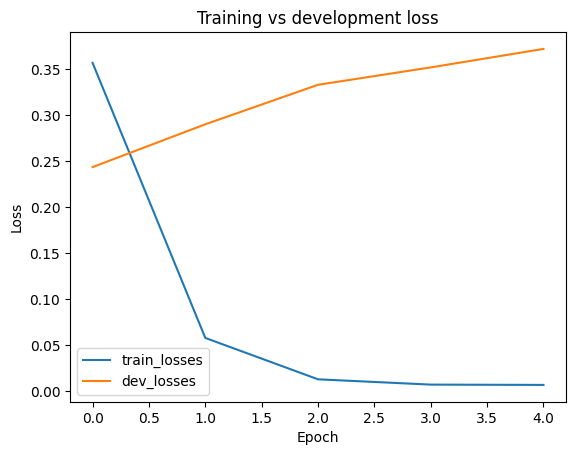

In [326]:
x = list(range(max_epoch))
            
plt.plot(x, train_losses, label ='train_losses')
plt.plot(x, dev_losses, label ='dev_losses')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training vs development loss')
plt.show()

### Question 4

- How would you explain the plot above? More specifically, is there one loss that goes down and the other that goes up in relation to different epochs? If so, why do you think this is the case?

## Evaluating a pytorch model

Here, the code below first predicts the output of the model for the test set, and then evaluates the performance on the test set.

In [410]:
def get_preds(model_pth, feats_test_text, tars_test_text):
    model_pth.eval() # to put the model into evaluation mode
    preds_test = []
    for feats, tars in zip(feats_test_text, tars_test_text):
        inputs = torch.tensor(feats).unsqueeze(0).float()
        labels = torch.tensor(tars).unsqueeze(0)
        outputs = model_pth(inputs).squeeze(0).detach().numpy()
        preds_test.append(np.argmax(outputs))
    return preds_test

best_epoch = np.argmin(dev_losses)
print("best epoch for development is:", best_epoch)
model_pth = torch.load(os.path.join(models_save_dir, f"{best_epoch}.pth")) # to load the best model based on development loss
preds_test = get_preds(model_pth, feats_test_text, tars_test_text)
preds_dev = get_preds(model_pth, feats_dev_text, tars_dev_text)
preds_train = get_preds(model_pth, feats_train_text, tars_train_text)

print("UAR train:", UAR(preds_train, tars_train_text))
print("UAR dev:", UAR(preds_dev, tars_dev_text))
print("UAR test:", UAR(preds_test, tars_test_text))

best epoch for development is: 0
UAR train: 0.9869800847616548
UAR dev: 0.9038276745675848
UAR test: 0.9052786499215071


## BERT

Any given text is first tokenised and numerically encoded in order to be represented for machines. It was discussed that the simplest approaches assign independent one-hot vectors to each token (e.g. word), which would not encode any semantic or syntactic information. Statistical approaches such as TF-IDF were then introduced, which could encode the statistical saliency of each token in different documents. However, TF-IDF is a rather rudimentary statistical measure and does not take any semantics into account. On the other hand, the advent of data-driven DNNs has led to the modelling of a language using such techniques, and in many cases abandoning the traditional techniques. In fact, the DNNs can be trained in an unsupervised manner to provide us with textual feature extraction that is shaped by the data and does not depend on any specific human knowledge of the domain. This trend has become particularly popular thanks to the attention mechanism, which allows neural networks to be effectively trained on large amounts of data.

The attention mechanism [see here](https://arxiv.org/abs/1706.03762) can be thought of as a machine learning method that can focus on the most important parts of the input. This is achieved by learning the weight of the input components and assigning greater importance to certain parts of the input. This allows the attention mechanism to focus on the relevant information and ignore the irrelevant parts, which can significantly improve the accuracy of sequential tasks. Although the attention mechanism can be defined in different ways, it is usually implemented as dot-product attention, and it can be mathematically written as follows: 

\begin{equation}
    A(Q, K) = QK^T
\end{equation}

where $A$ is the attention vector, calculated by the dot-product of $Q$ and $K$ vectors. Traditionally, the attention concept comes from retrieval systems, where a query ($Q$) is first compared to a set of keys ($K$), which are associated with a set of values ($V$). This way, the attention mechanism can map a query and a set of key-value pairs to an output, which can be computed as a weighted sum of the values. In order to compute the weighted sum of the values, a softmax function can be used on the attention vector $A$, in order to make the values describe a probability distribution. Furthermore, it is often assumed that $Q$ and $K$ vectors have $d_k$ dimensions, and that they have a random distribution with zero mean and $d_k$ variance. Thus, a common practice to divide them by $d_k$, in order for them to have zero mean and unit variance (this is known as scaling). Thus, a scaled dot-product attention can be calculated as follows:
\begin{equation}
    A(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V
\end{equation}

Moreover, in order to allow the attention mechanism to learn more complex representations of the data, multiple scaled dot-product attentions can also be used. This approach is called Multi-Head Attention, and is depicted in figure below:

![MHA](./Figs/MHA.png)

The advent of attention-based architectures, such as transformers, which are models consisting of multi-head attention (see figure below) and feed-forward layers, has accurate and complex language models that can better capture the context and thus have a better "understanding" of each input sentence as a whole. For example, `BERT` uses transformers to further improve the representation of a word by taking into account its context more effectively.

![BERT](./Figs/BERT.png)

### Loading a BERT model from huggingface

Huggingface is a development tool for machine learning methods and in particular for transformers. It is known for its large repository of different transformer models that are already trained and ready to be used for different purposes. Here we have shown how a BERT model such as [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) can be loaded into memory for use.

In [415]:
HF_model = "distilbert-base-cased"
tokenizer = DistilBertTokenizer.from_pretrained(HF_model)
model = DistilBertModel.from_pretrained(HF_model)
text = "Hello there"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
print(output[0].size())

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 4, 768])


### Extracting BERT features

Here, we pass our data through the BERT model in order to extract more contextual representations.

In [416]:
def extract_bert_feats(tokenizer, model, texts):
    feats = []
    for t, text in enumerate(texts):
        printProgressBar(t + 1, len(texts), prefix = 'extracting bert features:', suffix = 'complete', length=50)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)[0]
        #output = torch.mean(output.squeeze(0), 0).detach().numpy()
        output = output.squeeze(0).detach().numpy()
        feats.append(output)
    #return np.array(feats)
    return feats

feats_train_bert = extract_bert_feats(tokenizer, model, train_data[:,1])
feats_dev_bert = extract_bert_feats(tokenizer, model, dev_data[:,1])
feats_test_bert  = extract_bert_feats(tokenizer, model, test_data[:,1])

feats_train_bert_mean = [np.concatenate((np.mean(feats[1:-1], 0), np.std(feats[1:-1], 0))) for feats in feats_train_bert]
feats_dev_bert_mean   = [np.concatenate((np.mean(feats[1:-1], 0), np.std(feats[1:-1], 0))) for feats in feats_dev_bert]
feats_test_bert_mean  = [np.concatenate((np.mean(feats[1:-1], 0), np.std(feats[1:-1], 0))) for feats in feats_test_bert]

extracting bert features: |██████████████████████████████████████████████████| 100.0% complete
extracting bert features: |██████████████████████████████████████████████████| 100.0% complete
extracting bert features: |██████████████████████████████████████████████████| 100.0% complete


### Training an SVM model on BERT features

In [417]:
clf_bert = SVC(C=10.0, kernel='rbf')
clf_bert.fit(feats_train_bert_mean, tars_train_text)
preds = clf_bert.predict(feats_test_bert_mean)
print("Accuracy:", accuracy(preds, tars_test_text))
print("UAR:", UAR(preds, tars_test_text))

Accuracy: 0.8005115089514067
UAR: 0.8004905808477236


### Question 5

- Go back up to the loading a BERT model, and load [flaubert_large_cased](https://huggingface.co/flaubert/flaubert_large_cased) instead of the `distilbert-base-cased` (do not forget to also change the `tokenizer` and `model` as well as the `HF_model`). Then, run all the scripts again to see `flaubert_large_cased` achieves better performance than `distilbert-base-cased` in our case. Why do you think that is?


## Summary

In this practical work we started with a short summary of the previous practical work regarding loading the data and extracting `TF-IDF` measures to train `SVMs` using the `SKLearn` package. Then we were introduced to the basics of neural networks and how they can be trained using the back-propagation technique. Then we were introduced to the `PyTorch` package, which allows you to define, train and evaluate your own neural network model in a Python-friendly way. We also learned about the attention mechanism and the BERT architecture. We then learned how to use `Huggingface` to load different pre-trained `BERT` models and use them as textual feature extractors to train and evaluate machine learning models.